Бизнес-пользователям интересно увидеть тенденции и аномалии в данных, а также прогнозы на предстоящие 6 месяцев.
Страховые выплаты - это расходы, которые страховые компании должны оплачивать за медицинские услуги, предоставляемые пациентам.

* MONTH - месяц когда выплата была зафиксирована
* SERVICE_CATEGORY - департамент предоставивший сервис
* CLAIM_SPECIALTY - тип медицинской услуги предоставленной клиенту
* PAYER - страховая компания
* PAID_AMOUNT - сумма расходов (выплаты), $

In [235]:
# Импорт нужных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px

df = pd.read_csv('drive/MyDrive/claim.csv')
dfc = df.copy(deep=True)
# df.info()        # инфа о типах данных и количестве не нулевых значений по атрибутам
# df.describe()    # позволяет собрать некоторую статистику по каждому числовому признаку
pd.options.display.float_format = '{:,.1f}'.format  # округление выводимых значений до сотых

In [ ]:
# dfc.info()
# df.describe()
# pd.DataFrame(data=df.MONTH.unique()).head(50) # видим что есть 201900. что с ним делать?
# pd.DataFrame(data=dfc.SERVICE_CATEGORY.unique()).head(10)  # видим почти одинаковое значение SpecialistFFS и SpecialistsFFS
# len((dfc['CLAIM_SPECIALTY']).unique()) # 906 уникальных услуги
# len((dfc['PAYER']).unique()) # 10 уникальных страховых компании

* 52152 строки всего
* Пустые значения есть только в CLAIM_SPECIALTY
* В MONTH 32 уникальных значения. Есть значение 201900, которое нелогично - не может быть нулевого месяца года.
* В SERVICE_CATEGORY 9 уникальных значений. Есть подозрение что два значения про одно и то же SpecialistFFS и SpecialistsFFS
* В CLAIM_SPECIALTY 906 уникальных значений, но многие похожи и вероятно являются одной и той же услугой (пример: "Allergy", "ALLERGY & IMMUNOLOGY", "ALLERGY / IMMUNOLOGY", "Allergy/Immunology")
* В PAYER 10 уникальных страховых компании. 6 - однобуквенное имя, 4 - двубуквенное
* В PAID_AMOUNT есть положительные значения, отрицательные и нулевые.

In [249]:
# ВОЗМОЖНЫЕ ЧИСТКИ ДАННЫХ
# df_clear = dfc.drop(dfc[dfc.MONTH==201900].index)           # удаляем 00 месяц 2019 года, так как такого месяца не существует
# df_clear = df_clear.drop(df_clear[df_clear.PAID_AMOUNT < 0].index)         # удаляем отрицательные выплаты, так как невозможны выплаты обратно
# df_clear['PAID_AMOUNT'] = df_clear['PAID_AMOUNT'].abs()                          # делаем все отрицательные выплаты положительными, если минус это ошибка
# df_clear['CLAIM_SPECIALTY'] = df_clear['CLAIM_SPECIALTY'].fillna('unknown')      # заменям пустые значения на заглушку
# df_clear = df_clear.drop(dfc[dfc.PAID_AMOUNT == 0].index)                             # удаляем нулевые выплаты, так как они не несут полезной информации
# df_clear = df_clear.replace(to_replace='SpecialistsFFS', value='SpecialistFFS')  # заменяем SpecialistsFFS на SpecialistFFS (без s)


# df_clear = df
# df_clear.loc [ df_clear.PAID_AMOUNT >1000]
df_clear.info()
# df_clear.loc [ df_clear.CLAIM_SPECIALTY.isnull()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47976 entries, 0 to 47975
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             47976 non-null  int64 
 1   MONTH             47976 non-null  object
 2   SERVICE_CATEGORY  47976 non-null  object
 3   CLAIM_SPECIALTY   47976 non-null  object
 4   PAYER             47976 non-null  object
 5   PAID_AMOUNT       47976 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


In [240]:
df_month = df_clear.groupby(['MONTH'])['PAID_AMOUNT']\
   .agg(['sum'])\
   .sort_values(by='sum', ascending=False)\
   .head(1)
df_payer = df_clear.groupby(['PAYER'])['PAID_AMOUNT']\
   .agg(['sum'])\
   .sort_values(by='sum', ascending=False)\
   .head(1)
df_claim_sum = df_clear.groupby(['CLAIM_SPECIALTY'])['PAID_AMOUNT']\
   .agg(['sum'])\
   .sort_values(by='sum', ascending=False)\
   .head(1)
df_claim_cnt = df_clear.groupby(['CLAIM_SPECIALTY'])['PAID_AMOUNT']\
   .agg(['count'])\
   .sort_values(by='count', ascending=False)\
   .head(1)
df_service_sum = df_clear.groupby(['SERVICE_CATEGORY'])['PAID_AMOUNT']\
   .agg(['sum'])\
   .sort_values(by='sum', ascending=False)\
   .head(1)
df_service_cnt = df_clear.groupby(['SERVICE_CATEGORY'])['PAID_AMOUNT']\
   .agg(['count'])\
   .sort_values(by='count', ascending=False)\
   .head(1)
pd.concat([df_month, df_payer, df_claim_sum, df_claim_cnt, df_service_sum, df_service_cnt])

,sum,count
201905,"8,593,426.0",NaN
Payer F,"86,787,408.0",NaN
INP,"41,412,982.0",NaN
INTERNAL MEDICINE,NaN,"1,093.0"
InpatientServices,"87,861,676.0",NaN
SpecialistFFS,NaN,"13,408.0"


* Больше всего выплат получено за май 2019 - 8,5 млн
* Самая большая сумма выплат за всё время от Payer F - 86+ млн
* Больше всего выплат получено по услуге INP - 41,4 млн
* Больше всего выплат получено департаментом InpatientServices - 85 млн
* Чаще всего возмещали улугу INTERNAL MEDICINE - 1093 раза
* Чаше всего услугу оказывал департамент SpecialistFFS - 13408 раз

In [ ]:
df_negative = df [ df.PAID_AMOUNT < 0]
# dfc_negative.head(10)
df_neg_payer_sum = df_negative.groupby(['PAYER'])['PAID_AMOUNT']\
   .agg(['sum'])\
   .sort_values(by='sum', ascending=False)\
   .head(1)
df_neg_payer_cnt = df_negative.groupby(['PAYER'])['PAID_AMOUNT']\
   .agg(['count'])\
   .sort_values(by='count', ascending=False)\
   .head(1)

pd.concat([df_neg_payer_sum, df_neg_payer_cnt])

Если считать отрицательные выплаты, как негативных фактор для компании, то следует обратить внимание на следующие страховые:
1. Payer CO - им вернули наибольшую сумму за всё время
2. Payer UN - им чаще других возвращали


<Axes: title={'center': 'Общее соотношение суммарных выплат по месяцам между Страховыми компаниями'}, xlabel='MONTH'>

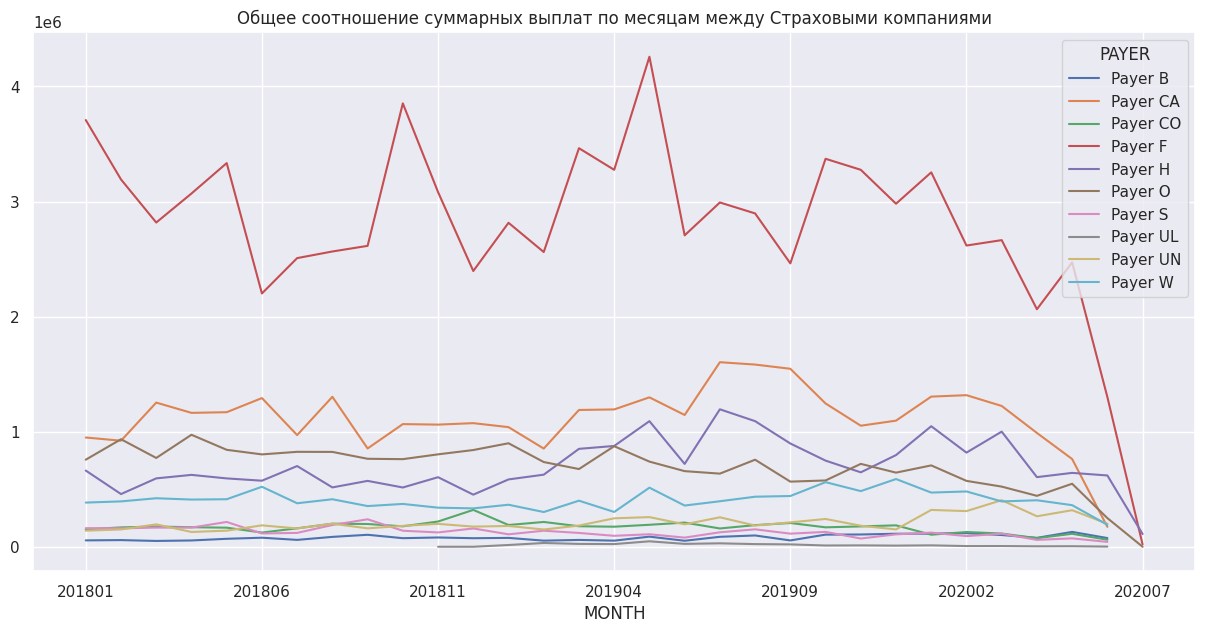

In [241]:
df_clear['MONTH'] = df_clear['MONTH'].astype(str) # нужно для корректного отображения на графике
dfpv_payer = df_clear.pivot_table(index='MONTH', columns='PAYER', values='PAID_AMOUNT', aggfunc='sum').reset_index()
dfpv_payer.plot(x='MONTH', figsize=(15,7), title='Общее соотношение суммарных выплат по месяцам между Страховыми компаниями')

* По графику выше можно увидеть что больше всего выплат приходится на Payer F.
* Нет видимых трендов от года к году ни по одной Страховой.
* Начиная с января 2020 года виден тренд на снижение сумм выплат

<Axes: title={'center': 'Общее соотношение суммарных выплат по месяцам между Департаментами'}, xlabel='MONTH'>

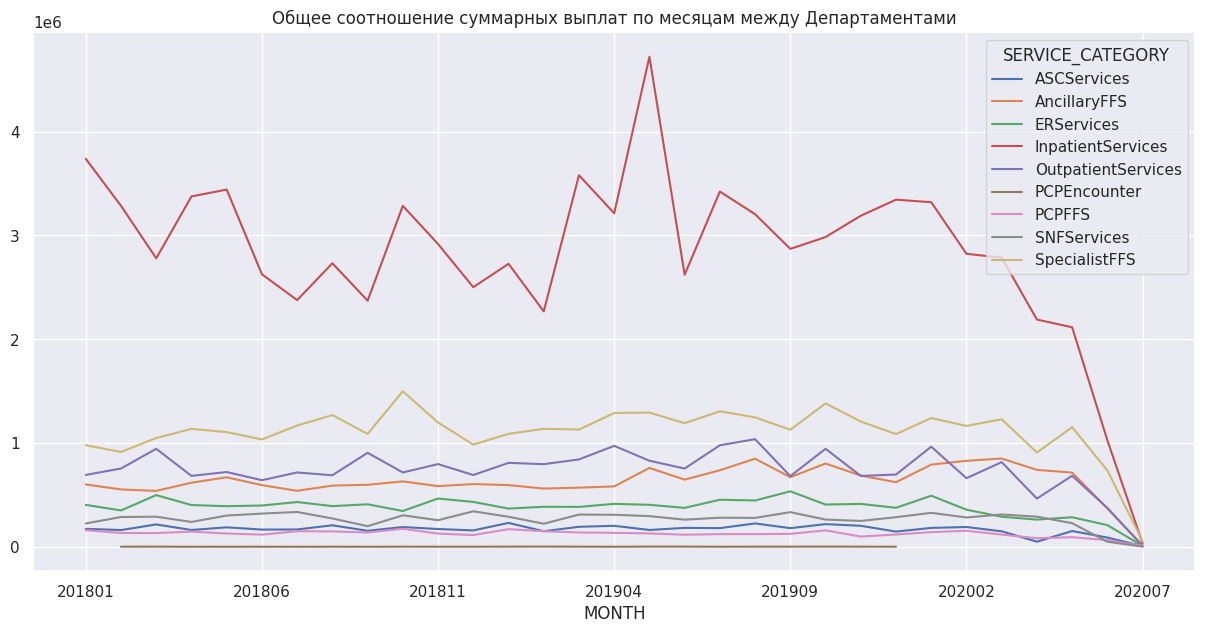

In [242]:
dfpv_service = df_clear.pivot_table(index='MONTH', columns='SERVICE_CATEGORY', values='PAID_AMOUNT', aggfunc='sum').reset_index()
dfpv_service.plot(x='MONTH', figsize=(15,7), title='Общее соотношение суммарных выплат по месяцам между Департаментами')

* По графику видно что на всем периоде больше всего выплат приходится на департамент InpatientServices
* Заметен резкий рост выплат в InpatientServices за март-май 2019, с последующим спадом до среднего значения.

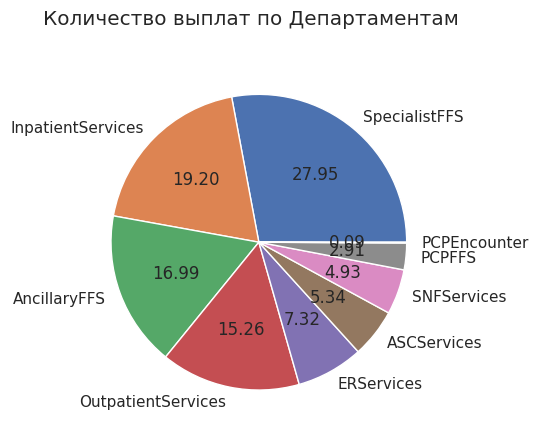

In [243]:
dfgr_service = df_clear.groupby(by='SERVICE_CATEGORY', sort=False)['PAID_AMOUNT'].count().sort_values(ascending=False)
claim_pie = pd.Series(dfgr_service).plot.pie(subplots=True, label='', autopct = '%.2f', title='Количество выплат по Департаментам')

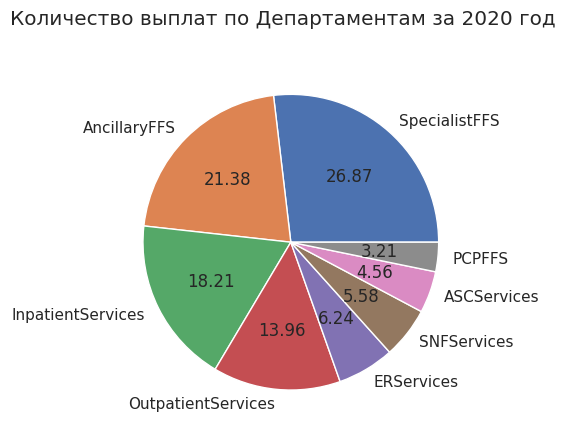

In [245]:
dfc_2020 = df_clear.loc [ df_clear.MONTH >= '202001']
dfgr2020_service = dfc_2020.groupby(by='SERVICE_CATEGORY', sort=False)['PAID_AMOUNT'].count().sort_values(ascending=False)
claim_pie = pd.Series(dfgr2020_service).plot.pie(subplots=True, label='', autopct = '%.2f', title='Количество выплат по Департаментам за 2020 год')

In [251]:
# import plotly.express as px
dfc_gr = df_clear.groupby(by=['PAYER','MONTH'], sort=False)['PAID_AMOUNT']\
        .agg(['sum','count']).sort_values(by=['MONTH','PAYER'], ascending=True).reset_index()
px.scatter(dfc_gr, x='PAYER', y='sum', animation_frame='MONTH'\
           , range_x=[-1,11], range_y=[-500000, 5000000], size='count'\
           , title='Динамика изменения суммы выплат с учетом их количества')

In [252]:
dfc_gr = df_clear.groupby(by=['MONTH'], sort=False)['PAID_AMOUNT']\
       .agg(['sum','count']).sort_values(by='MONTH', ascending=True).reset_index()

px.line(dfc_gr, x='MONTH', y='sum')

Идеи гипотез на проверку:
1) Есть ли выплаты с одинаковой суммой, услугой, плательщиком и месяце, но разный департамент.